#### Architecture of a classification neural network
* Input layer shape (in_features)
* Hidden layer(s)
* Neurons per hidden layer (generally 10-512)
* Output layer shape (1, one class or the other)
* Hidden layer activation (usually ReLU, but many other options)
* Output activation (sigmoid)
* Loss function (binary crossentropy)
* Optimizer (stochastic gradient descent)

In [22]:
# get some data going
from sklearn.datasets import make_circles
n_samples = 1000
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [23]:
print(f"First 5 X features:\n{X[:5]}")
print(f"First 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 y labels:
[1 1 1 1 0]


In [24]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y
                       })
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [25]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

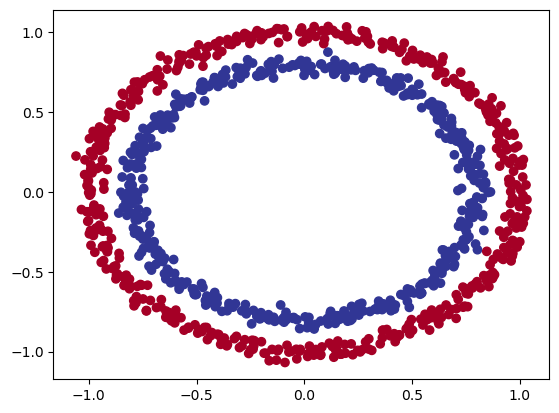

In [26]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
           y=X[:, 1],
           c=y,
           cmap=plt.cm.RdYlBu)
plt.show()

#### Goal: build a model to classify between blue or red

In [27]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shape for one sample of X: (2,) and the same for y: ()


* `(2,)` => 2 dimensional meaning it's a matrix
* `(1,)` => 1 dimensional meaning it's a vector
* `()` => 0 dimensional meaning it's a scalar

In [28]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [29]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

* increasing the feature count from 2 to 5 allows the network to learn from 5 features rather than 2 increasing it's accuracy and ability to learn

In [31]:
untrained_preds = model_0(X_test.to(device))
print(f"First 10 predictions:\n{untrained_preds[:10]}")
print(f"First 10 test labels:\n{y_test[:10]}")

First 10 predictions:
tensor([[-0.2695],
        [-0.1759],
        [-0.3192],
        [-0.2562],
        [-0.0087],
        [ 0.0460],
        [ 0.0634],
        [ 0.1162],
        [-0.3322],
        [-0.1662]], grad_fn=<SliceBackward0>)
First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [32]:
loss_fn = nn.BCEWithLogitsLoss() # sigmoid built in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

#### Evaluation metric
* can be used to offer another perspective on how well the model is doing
* example: accuracy

In [33]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [35]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2695],
        [-0.1759],
        [-0.3192],
        [-0.2562],
        [-0.0087]], grad_fn=<SliceBackward0>)

* `nn.Linear()` internally looks like `y = x * <Weights> + bias`
* the raw outputs or unnormalized predictions of a model are referred to as logits

In [37]:
# prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4330],
        [0.4561],
        [0.4209],
        [0.4363],
        [0.4978]], grad_fn=<SigmoidBackward0>)

* `y_pred_probs` >= 0.5 `y=1`
* `y_pred_probs` < 0.5 `y=0`

In [43]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [48]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

import time
start_time = time.time()

for epoch in range(epochs):
    model_0.train() # training mode
    
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model_0.eval() # evaluation mode
        with torch.inference_mode():
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            test_loss = loss_fn(test_logits,
                           y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

end_time = time.time()
exec_time = end_time - start_time
print(f"Training time: {exec_time:.5f}s")

Epoch: 0 | Loss: 0.69, Accuracy: 49.62% | Test loss: 0.69616, Test acc: 49.00%
Epoch: 10 | Loss: 0.69, Accuracy: 50.12% | Test loss: 0.69607, Test acc: 49.00%
Epoch: 20 | Loss: 0.69, Accuracy: 50.25% | Test loss: 0.69600, Test acc: 48.50%
Epoch: 30 | Loss: 0.69, Accuracy: 50.25% | Test loss: 0.69592, Test acc: 49.00%
Epoch: 40 | Loss: 0.69, Accuracy: 50.12% | Test loss: 0.69586, Test acc: 49.50%
Epoch: 50 | Loss: 0.69, Accuracy: 50.00% | Test loss: 0.69579, Test acc: 49.00%
Epoch: 60 | Loss: 0.69, Accuracy: 50.00% | Test loss: 0.69573, Test acc: 49.00%
Epoch: 70 | Loss: 0.69, Accuracy: 49.88% | Test loss: 0.69568, Test acc: 48.00%
Epoch: 80 | Loss: 0.69, Accuracy: 50.38% | Test loss: 0.69562, Test acc: 48.00%
Epoch: 90 | Loss: 0.69, Accuracy: 50.12% | Test loss: 0.69557, Test acc: 47.50%
Training time: 0.02710s


In [49]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

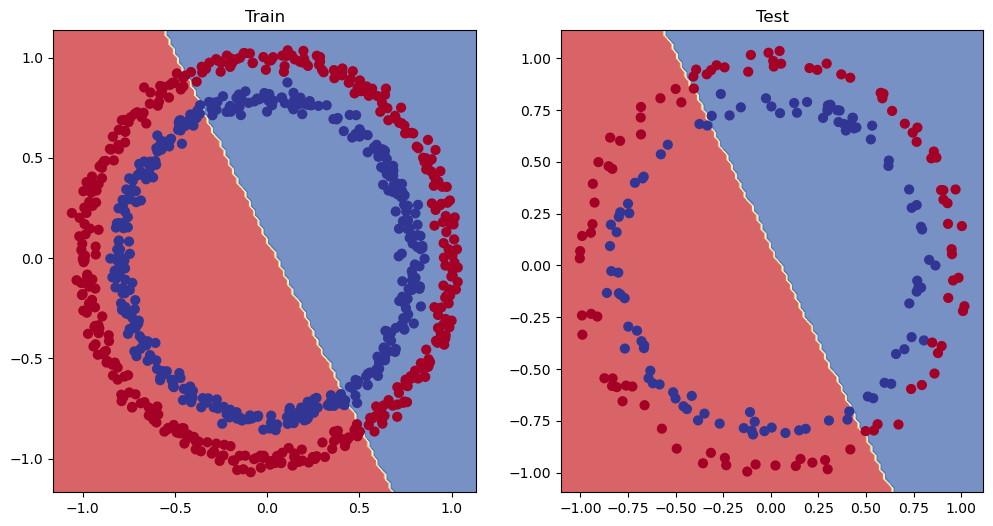

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.show()

* our model is underfitting

#### Ways to improve our model
* Add more layers
* Add more hidden units
* Fitting for longer (more epochs)
* Changing the activation functions
* Changing the learning rate
* Change the loss function
* Use transfer learning (take a pretrained model from a similar domain and adjust it for your application)

#### The missing piece here: non-linearity
* What's needed? Non-linear activation functions

In [52]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [53]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [54]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) 
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


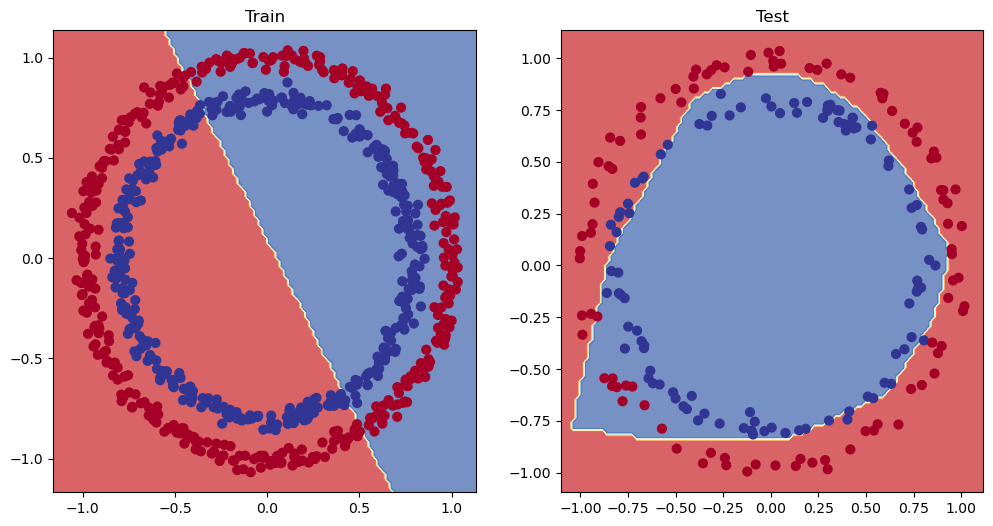

In [56]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

* understanding a non-linear activation function

In [57]:
A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

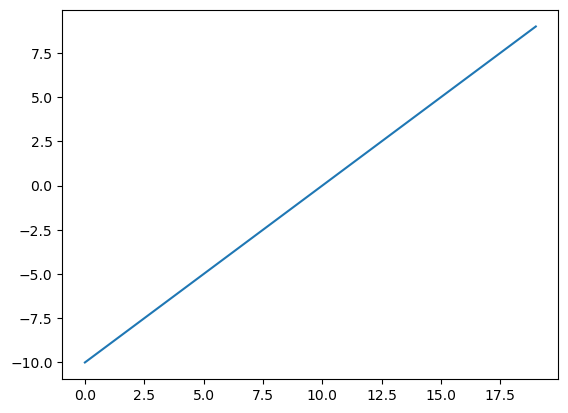

In [60]:
plt.plot(A)
plt.show()

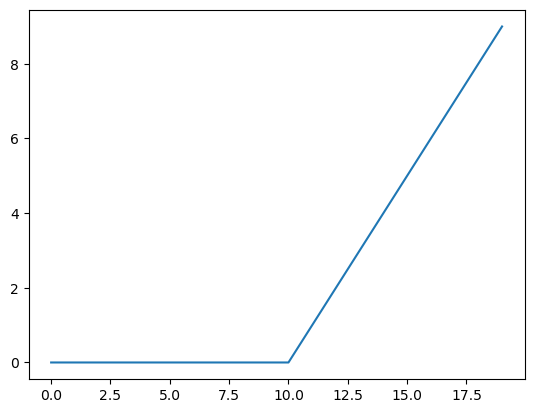

In [63]:
# relu is, if val is < 0, change to 0, else keep the same
def relu(x):
    return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))
plt.show()

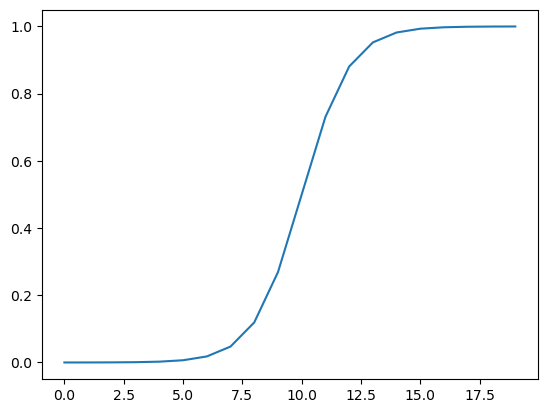

In [64]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))
plt.show()